In [1]:
import pylab as plt
plt.style.use('dark_background')
import math
import torch
import sys
sys.path.append('./pytorch_nufft')
import nufft
import skimage.transform
from skimage.data import shepp_logan_phantom

def Ft(x):
    x = torch.fft.ifftshift(x, dim=(-1,-2))
    x = torch.fft.fftn(x, dim=(-1,-2))
    x = torch.fft.fftshift(x, dim=(-1,-2))
    return x

def IFt(x):
    x = torch.fft.ifftshift(x, dim=(-1,-2))
    x = torch.fft.ifftn(x, dim=(-1,-2))
    x = torch.fft.fftshift(x, dim=(-1,-2))
    return x

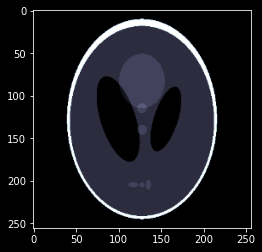

In [2]:
img = torch.tensor(skimage.transform.resize(shepp_logan_phantom(), (256,256)))[None, None].cfloat()
plt.imshow(img[0,0].abs(), cmap=plt.cm.bone)
plt.show()

In [4]:
res = 32
x, y = torch.meshgrid([
    torch.linspace(-img.shape[2]//16, img.shape[2]//16, res), 
    torch.linspace(-img.shape[3]//16, img.shape[3]//16, res), 
])
grid = torch.stack([x.flatten(), y.flatten()])
dcf = (grid[0]**2 + grid[1]**2)**0.5

In [5]:
img.shape, grid.shape

(torch.Size([1, 1, 256, 256]), torch.Size([2, 1024]))

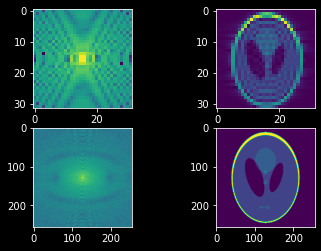

In [6]:
ks = nufft.nufft(img, grid.T, device='cpu')[0,0].reshape(res,res).contiguous()
plt.subplot(221)
plt.imshow(ks.abs().log())
plt.subplot(222)
plt.imshow(IFt(ks).abs())
ks = Ft(img[0,0]).contiguous()
plt.subplot(223)
plt.imshow(ks.abs().log())
plt.subplot(224)
plt.imshow(IFt(ks).abs())
plt.show()

In [8]:
res = 32
x, y = torch.meshgrid([
    torch.linspace(-img.shape[2]//16, img.shape[2]//16, res), 
    torch.linspace(-img.shape[3]//16, img.shape[3]//16, res), 
])
grid = torch.stack([x.flatten(), y.flatten()])
grid.requires_grad = True
dcf = (grid[0]**2 + grid[1]**2)**0.5

ks = nufft.nufft(img.abs(), grid.T, device='cpu')[0,0].reshape(res,res)
rimg = nufft.nufft_adjoint(ks, grid.T, out_shape=(1, res, res), device='cpu')
# rimg = IFt(ks).abs()
loss = rimg.sum()
loss.backward()